# 20. 난 스케치를 할 테니 너는 채색을 하거라

## 13. 프로젝트 : Segmentation map으로 도로 이미지 만들기
이전 Pix2Pix 논문에서 제시한 결과 중에 아래와 같은 실험 결과가 있었습니다. 도로의 레이블 정보를 활용해 이미지를 생성해낸 결과입니다.

<img src="./image/p2p_result.png" />

이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것입니다. 데이터셋은 아래에서 다운로드할 수 있다.<br>
1000개의 학습용 이미지 및 5개의 평가 이미지를 포함한다.

이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없다.<br>
아래 Tensroflow에서 제공하는 Pix2Pix 튜토리얼은 위 이미지와 비슷한 레이블 정보 이미지를 사용하기 때문에 좋은 참고 자료가 될 수 있을 것 같다.

프로젝트 시작에 어려움이 있다면 아래 튜토리얼을 참고하시면서 이번 프로젝트를 수행해보자.<br>
(아래 튜토리얼은 Pix2Pix 구조를 Functional API를 이용해 구현하기 때문에 이번에 진행한 Subclassing 방법을 이용한 모델 구현과 비교하면서 구현 방법에 대해서도 공부해보자)

* [Tensorflow Pix2Pix Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)

### 프로젝트 수행
---
프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같다.

1. 데이터에 한 가지 이상의 __augmentation 방법을 적용__하여 학습하자.<br>
(어떠한 방법을 사용했는지 적자.)
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 __U-Net Generator를 사용__해보자.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트한다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용하자.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 __스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화__하자.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있다. 적어도 10 epoch 이상 학습하며 __중간 손실 값에 대한 로그__를 남기자. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮다.

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
import os

data_path = os.getenv('HOME')+'/AIFFEL/Exploration/E20_Pix2Pix/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


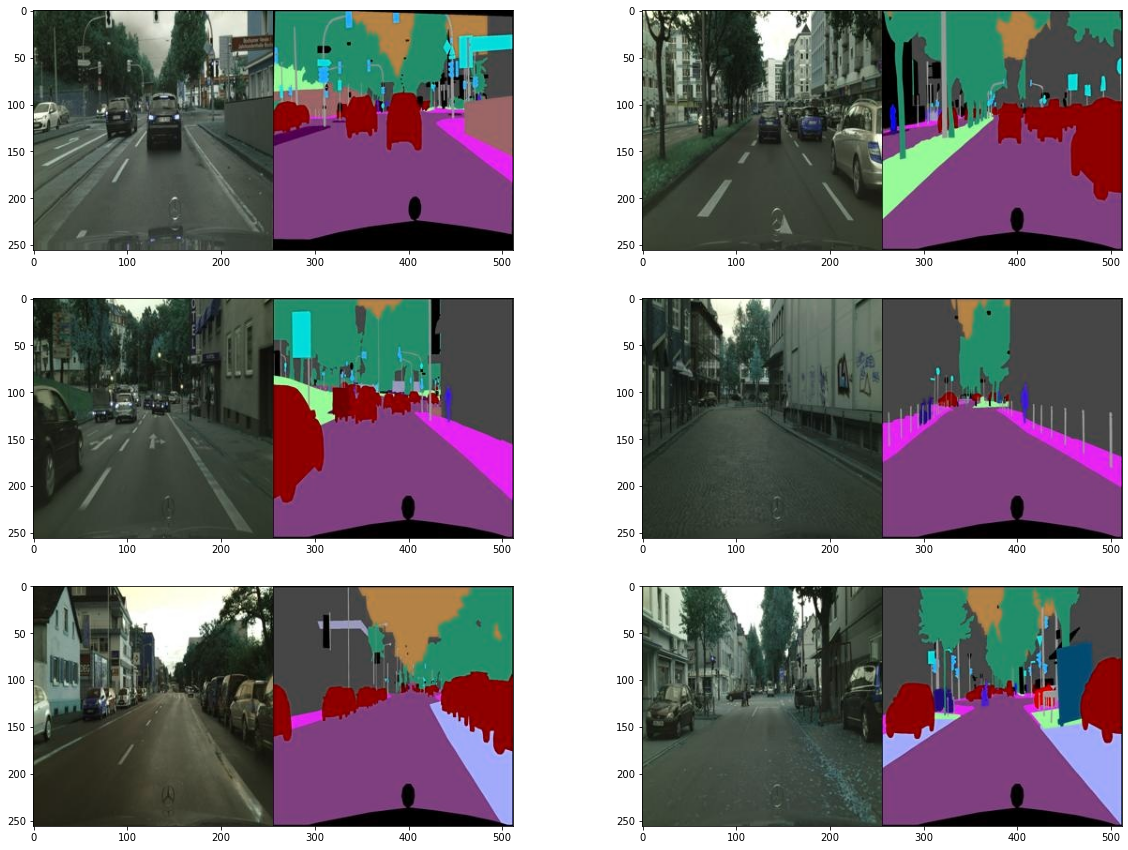

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


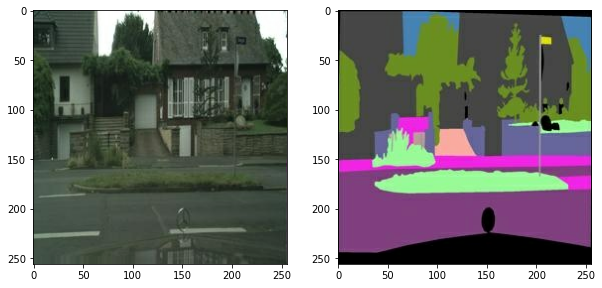

In [5]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [6]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

`apply_augmentation` 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용한다.

__apply_augmentation 함수에 두 이미지가 입력되면 거치는 과정__

1. 두 이미지가 채널 축으로 연결된다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 된다.
2. 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼 적용된다. (tf.pad)
3. 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라낸다. (tf.image.random_crop) 
4. 3.의 결과를 50% 확률로 가로로 뒤집는다. (tf.image.random_flip_left_right)
5. 4.의 결과를 50% 확률로 세로로 뒤집는다. (tf.image.random_flip_up_down) 
6. 5.의 결과를 50% 확률로 회전시킨다. (tf.image.rot90)

위와 같이 구성한 함수를 데이터에 적용해 시각화 해보자.

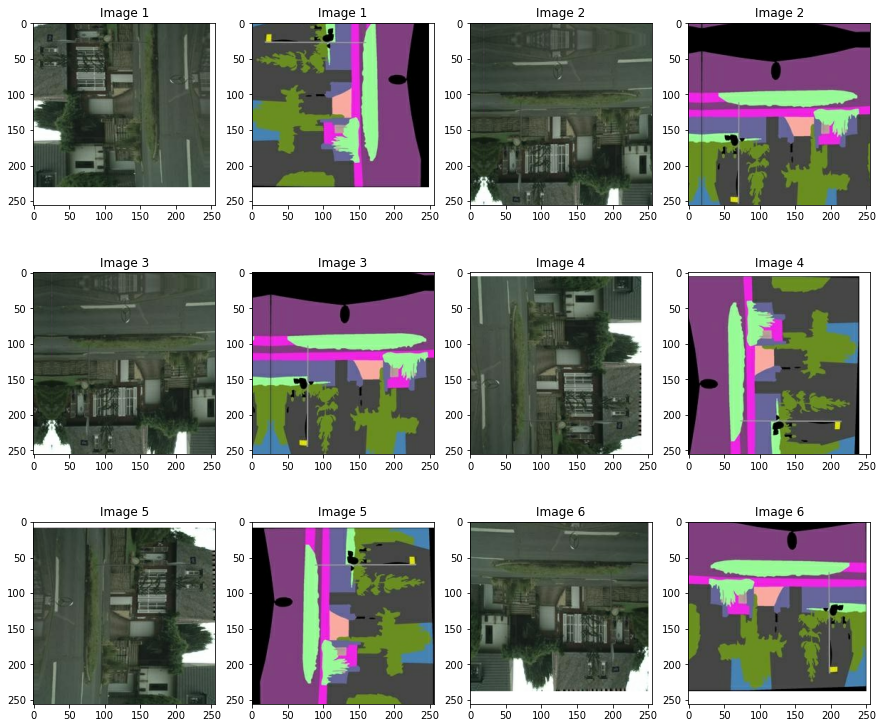

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

매우 다양한 이미지가 생성된다. 여기서 사용한 augmentation 방법 외에 더 많은 방법을 활용한다면 더욱더 다양한 데이터셋을 만들어 좋은 일반화 결과를 기대해 볼 수 있다.

마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해 보겠다.

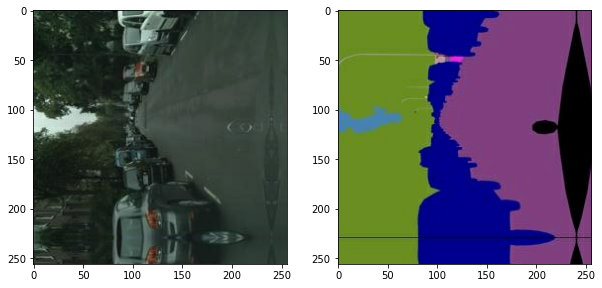

In [8]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 9. 난 스케치를 할 테니 너는 채색을 하거라 (2) Generator 구성하기
이제부터 본격적으로 Pix2Pix 구조를 구현한다. 앞서 cGAN 구현과 같이 Tensorflow의 Subclassing 방법을 이용해 모델을 만들겠다.

### Generator의 구성요소 알아보기
---
먼저, pix2pix 논문에서 Generator를 구성하는데 필요한 정보를 아래에 가져왔다.

<img src="./image/generator2.png"/>

__encoder의 "C64"의 하이퍼파라미터__

* 64개의 4x4 필터에 stride 2를 적용한 Convolution → 0.2 slope의 LeakyReLU

__decoder의 "CD512"의 하이퍼파라미터__

* 512개의 4x4 필터에 stride 2를 적용한 (Transposed) Convolution → BatchNorm → 50% Dropout → ReLU

이번에는 아래와 같이 보기 쉽게 표현한 그림을 통해 Generator의 전체 구조를 머리속에 조금 더 자세히 그려보자.

<img src="./image/encode_decode.png"/>

위 그림에서 `ENCODE` 또는 `DECODE`라고 쓰인 각각의 블록을 기준으로 양쪽에 쓰인 입출력 크기에 집중해보자.<br>
"in"이라고 쓰여진 입력 부분부터 윗줄의 화살표를 쭉 따라가면 계산된 결과의 (width, height) 크기가 점점 절반씩 줄어들며 최종적으로 (1,1)이 되고, 채널의 수는 512까지 늘어나는 것을 확인할 수 있다.<br>
처음 입력부터 시작해서 (1,1,512) 크기를 출력하는 곳까지가 Encoder 부분이다.

이어서 아랫줄 화살표를 따라가면 (width, height) 크기가 점점 두 배로 늘어나 다시 (256, 256) 크기가 되고, 채널의 수는 점점 줄어들어 처음 입력과 같이 3채널이 된다. (1,1,512)를 입력으로 최종 출력까지의 연산들이 Decoder 부분이다.

### Generator 구현하기
---
위 정보들을 토대로 Generator의 Encoder 부분을 구현하겠다.<br>
먼저 위 논문에서 "C64", "C128" 등으로 쓰여진 것과 같이 "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만들었다.

In [9]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

`__init__()` 메서드에서 `n_filters`, `use_bn`를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정 할 수 있다.<br>
이외 Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정했다.<br>
Encoder에 사용할 기본 블록을 구성했으니 이 블록을 여러 번 가져다 사용하면 아래와 같이 쉽게 Encoder를 구성할 수 있다.

In [10]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

각 블록을 거치면서 사용할 필터의 개수를 `filters`라는 리스트에 지정해 두었으며, `blocks`이라는 리스트에는 사용할 블록들을 정의해 넣어두고, `call()` 메서드에서 차례대로 블록들을 통과한다. 앞서 알아본 것처럼 Encoder 첫 번째 블록에서는 BatchNorm을 사용하지 않는다.<br>
`get_summary`는 레이어가 제대로 구성되었는지 확인하기 위한 용도로 따로 만들어 놓았다. 위에서 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 살펴보자. 만들어 놓은 `get_summary` 메서드를 바로 불러오면 된다.

In [11]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인 할 수 있다.

이번엔 Decoder를 구현합니다. Encoder와 마찬가지로 사용할 기본 블록을 정의하고, 이 블록을 여러 번 반복하여 아래와 같이 Decoder를 만들겠다.

In [12]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

처음 세 개의 블록에서만 `Dropout`을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인할 수 있다.<br>
마찬가지로 (1,1,512) 크기의 데이터가 입력되었을 때, 어떤 크기가 출력되는지 확인해보자.

In [13]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

(width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 알맞게 출력되었다.

위에서 구성한 Encoder와 Decoder를 연결시키면 Encoder에서 (256,256,3) 입력이 (1,1,512)로 변환되고, Decoder를 통과해 다시 원래 입력 크기와 같은 (256,256,3)의 결과를 얻을 수 있다. 스케치를 입력으로 이런 연산 과정을 통해 채색된 이미지 출력을 얻을 수 있다.<br>
아래 코드와 같이 `tf.keras.Model`을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성해보자.

In [14]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


Generator를 잘 작동시키기 위해서는 약 4000만 개의 파라미터를 잘 학습시켜야 한다.

## 10. 난 스케치를 할 테니 너는 채색을 하거라 (3) Generator 재구성하기
지금까지 Encoder와 Decoder를 연결시켜 Generator를 만들어 보았다.<br>
하지만 Pix2Pix의 Generator 구조는 아래 그림처럼 두 가지를 제안했다.<br>
아래 그림으로 다시 한번 보자.

<img src="./image/p2p4.png"/>

위 그림에서 각 구조 아래에 표시된 이미지는 해당 구조를 Generator로 사용했을 때의 결과이다.

단순한 Encoder-Decoder 구조에 비해 Encoder와 Decoder 사이를 skip connection으로 연결한 U-Net 구조를 사용한 결과가 훨씬 더 실제 이미지에 가까운 품질을 보인다.

이전 단계에서 구현했던 Generator는 위 그림의 Encoder-decoder 구조이다.<br>
Encoder에서 출력된 결과를 Decoder의 입력으로 연결했고, 이 외에 추가적으로 Encoder와 Decoder를 연결시키는 부분은 없었다. 더 좋은 결과를 기대하기 위해 이전에 구현했던 것들을 조금 수정하여 위 그림의 U-Net 구조를 만들고 실험해보자.<br>
(아래 단락부터는 두 가지 구조를 각각 "Encoder-Decoder Generator" 및 "U-Net Generator"라는 용어로 구분하여 사용했다.)

먼저 Encoder 및 Decoder에 사용되는 기본적인 블록은 이전에 아래 코드와 같이 구현했었다.

In [15]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

여기서 특별히 수정해야 할 부분은 없다. 그대로 가져다가 사용하자.

정의된 블록들을 이용해 한 번에 __U-Net Generator__를 정의해 보겠다. 아래 모델의 `__init__()` 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고, `call()`에서 forward propagation 하도록 한다. 이전 구현에는 없었던 skip connection이 `call()` 내부에서 어떻게 구현되었는지 잘 확인해보자.

In [16]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

먼저, `__init__()` 에서 정의된 `encode_blocks` 및 `decode_blocks`가 `call()` 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행한다.<br>
이때, Encoder와 Decoder 사이의 skip connection을 위해 `features` 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담았다.<br>
이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데,
`features` 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용된다.

__위 코드의 `call()` 내에서 'features = features[:-1]' 는 왜 필요할까?__

* Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아니다.

__위 코드의 call() 내의 Decoder 연산 부분에서 features[::-1] 는 왜 필요할까?__

* Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는.. 등 대칭을 이룬다(맨 위 U-Net 구조 사진 참고). 
* features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결한다.

__데이터 A 크기 : (32,128,128,200) #(batch, width, height, channel)__<br>
__데이터 B 크기 : (32,128,128,400) #(batch, width, height, channel)__<br>
__여기서 사용되는 skip connection은 `layers.Concatenate()` 결과의 크기는 무엇일까?__

* (128,128,600)
* `layers.Concatenate()` 내에 별다른 설정이 없다면 가장 마지막 축(채널 축)을 기준으로 서로 연결된다.

이제야 Generator 구현이 끝났다.

마지막으로 완성된 U-Net 구조 Generator 내부의 각 출력이 적절한지 아래 코드로 확인해보자.

In [17]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

이전 Encoder-Decoder Generator 구조에서 학습해야 할 파라미터는 약 4000만 개 였는데, Skip connection을 추가한 U-Net Generator의 파라미터는 약 5500만 개로 꽤나 많이 늘어났다.

__U-Net Generator의 파라미터가 늘어난 곳은 Encoder와 Decoder 중 어디일까? 또한, 두 종류의 Generator 구조에서 동일한 수의 convolution 레이어를 사용했는데, 구체적으로 어느 부분에서 파라미터가 늘어났을까?__

* U-Net Generator의 Decoder 구조 내 파라미터가 많아졌다. 이 부분의 각 convolution 레이어에서 사용된 필터의 수는 두 종류의 Decoder에서 동일하지만, 그 크기가 다르다. 
* 예를 들어, 이전 Decoder 블록의 출력의 크기가 (16,16,512)라면,
* Encoder-decoder Generator의 경우, Decoder의 다음 블록에서 계산할 convolution의 필터 크기는 4x4x512 이다.
* U-Net Generator의 경우, Encoder 내 블록 출력이 함께 연결되어 Decoder의 다음 블록에서 계산할 convolution의 필터 크기는 4x4x(512+512) 이다.

정리하면, U-Net Generator에서 사용한 skip-connection으로 인해 Decoder의 각 블록에서 입력받는 채널 수가 늘어났고, 이에 따라 블록 내 convolution 레이어에서 사용하는 필터 크기가 커지면서 학습해야 할 파라미터가 늘어났다.

## 11. 난 스케치를 할 테니 너는 채색을 하거라 (4) Discriminator 구성하기
Generator만으로 좋은 결과를 도출하기에는 부족하다. 조금 더 사실적인 이미지를 생성하기 위한 Pix2Pix를 완성시키기 위해서는 Discriminator가 필요하다.<br>
이번 단계에서 Discriminator를 만들어 Pix2Pix 구조를 완성시켜보자.

### Discriminator의 구성요소 알아보기
---
Generator를 만들기 전에 봤듯이 먼저 Pix2Pix 논문에서 Discriminator를 구성하는데 필요한 정보를 아래에 가져왔다.

<img src="./image/discriminator4.png" />

Generator의 구성 요소와 똑같이 "C64" 등으로 표기되어있다. 진짜 및 가짜 이미지를 판별하기 위해 최종 출력에 sigmoid를 사용하는 것을 제외하면 특별한 변경 사항은 없는 것 같다.

이어서 아래의 보기 쉽게 표현한 그림을 통해 Discriminator의 구조를 머리속에 조금 더 자세히 그려보자.

<img src="./image/discriminator5.png" />

Discriminator는 2개 입력(위 그림의 "in", "unknown")을 받아 연결(CONCAT)한 후, `ENCODE` 라고 쓰인 5개의 블록을 통과한다. 이 중 마지막 블록을 제외한 4개 블록은 위 논문에서 표기된 "C64-C128-C256-C512"에 해당하며, 마지막은 1(채널)차원 출력을 위한 블록이 추가되었다.

최종적으로 출력되는 크기는 (30,30,1) 이며, 위 그림의 출력 이전의 2개의 `ENCODE` 블록을 보면 각각의 출력 크기가 32, 31, 30으로 1씩 감소하는 것을 알 수 있다. Generator에서도 사용했던 2 stride convolution에 패딩을 이용하면 (width, height) 크기가 절반씩 감소할 것이다. 1 stride convolution에 패딩을 하지 않는다면 (width, height) 크기는 (필터 크기가 4이므로) 3씩 감소할 텐데, 그림과 같이 1씩 감소하도록 하려면 무언가 다른 방법을 써야 할 것 같다.

추가적으로 위 그림에서 최종 출력 크기가 (30,30)이 되어야 하는 이유는 앞서 Discriminator에 대해 알아봤던 70x70 PatchGAN을 사용했기 때문이다. 최종 (30,30) 출력에서 각 픽셀의 receptive field 크기를 (70,70)으로 맞추기 위해 Discriminator의 출력 크기를 (30,30) 크기로 강제로 맞추는 과정이다.

* [Understanding PatchGAN](https://medium.com/@sahiltinky94/understanding-patchgan-9f3c8380c207)

이 부분만 제외하면 전반적으로는 Generator보다 간단한 것 같다. 구현해보자.

### Discriminator 구현하기
---
마찬가지로 Discriminator에 사용할 기본적인 블록부터 만들겠다.

In [18]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

`__init__()` 에서 필요한 만큼 많은 설정을 가능하게끔 했다. 필터의 수(`n_filters`), 필터가 순회하는 간격(`stride`), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(`custom_pad`), BatchNorm의 사용 여부(`use_bn`), 활성화 함수 사용 여부(`act`)가 설정 가능하다.

__위에서 만든 DiscBlock의 설정을 다음과 같이 하여 DiscBlock(n_filters=64, stride=1, custom_pad=True, use_bn=True, act=True) 으로 생성된 블록에 (width, height, channel) = (128, 128, 32) 크기가 입력된다면, 블록 내부에서 순서대로 어떠한 레이어를 통과하는지, 그리고 각 레이어를 통과했을 때 출력 크기는 어떻게 될까?__

1. 패딩 레이어 통과 layers.ZeroPadding2D() → (130,130,32)  
2. Convolution 레이어 통과 layers.Conv2D(64,4,1,"valid") → (127,127,64)  
3. BatchNormalization 레이어 통과  layers.BatchNormalization() → (127,127,64)  
4. LeakyReLU 활성화 레이어 통과 layers.LeakyReLU(0.2) → (127,127,64)

1. (128,128,32) 크기의 입력이 `layers.ZeroPadding2D()`를 통과하면, width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어난다. 출력 : (130,130,32)
2. 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어든다. 이는 `OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1` 의 식으로 계산할 수 있다. 채널 수는 사용한 필터 개수와 같다. 출력 : (127,127,64)
3. 이 외 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않는다.

간단하게 코드를 작성하여 각 출력의 크기가 맞는지 확인해보자.

In [19]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


이러한 코드와 비슷한 설정으로 (width, height) 크기를 1씩 감소시킬 수 있습니다. 마지막 2개 블록은 출력의 크기가 1씩 감소하므로 이런 방식을 적용하면 되겠다.

Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30,30) 크기로 맞추느라 위와 같이 조금 복잡한 과정을 설명했다.<br>
사용할 기본적인 블록을 만들었으니 이를 이용해 바로 Discriminator를 만들어보자.

In [20]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

`__init__()` 내부에서 사용할 블록들을 정의했는데, 이전의 구현들처럼 (위 코드의 주석 처리된 부분과 같이) for loop로 간편하게 블록을 만들 수도 있지만, 쉽게 코드를 읽게끔 총 6개 블록을 각각 따로 만들었다.<br>
첫 번째 블록은 단순한 연결(`concat`)을 수행하며, Discriminator의 최종 출력은 `sigmoid` 활성화를 사용했다.

각 블록의 출력 크기가 알맞게 되었는지 아래 코드로 확인해보자.

In [21]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만들었고, 아래의 Discriminator를 나타낸 그림과 각 출력 크기가 일치한다.

<img src="./image/discriminator5.png" />

시험 삼아 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화해보겠다.

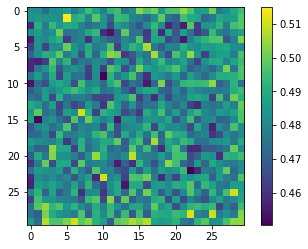

In [22]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

이전 PatchGAN에 대해 설명했던 것처럼, 위 (30,30) 크기를 갖는 결과 이미지의 각 픽셀값은 원래 입력의 (70,70) 패치에 대한 분류 결과이다. 전체 입력의 크기가 (256,256) 이므로, 각각의 (70,70) 패치는 원래 입력상에서 많이 겹쳐있다. 각각의 픽셀값은 `sigmoid` 함수의 결괏값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해내는 데 사용한다.

드디어 Pix2Pix를 구성하는 Generator와 Discriminator의 구현이 끝났다.<br>
다음 단계에서 본격적인 모델 학습을 진행해보자

## 12. 난 스케치를 할 테니 너는 채색을 하거라 (5) 학습 및 테스트하기
이번 단계에서는 구현된 Generator와 Discriminator를 학습시켜보고, 스케치를 입력으로 채색된 이미지를 생성해보자. 먼저 학습에 필요한 손실함수부터 정의하겠다.<br>
논문의 여러 실험 결과 중 손실함수 선택에 따른 결과의 차이는 아래와 같다.

<img src="./image/p2p5.png" />

레이블 정보만 있는 입력에 대해 여러 손실함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해냈다. 이번 실험에서도 두 가지 손실 함수를 모두 사용해보자.

In [23]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

Generator 및 Discriminator의 손실 계산을 각각 정의했다.

* Generator의 손실함수 (위 코드의 `get_gene_loss`)는 총 3개의 입력이 있다. 이 중 `fake_disc`는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 `tf.ones_like()`를 사용한다. 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(`fake_output`)와 실제 이미지(`real_output`) 사이의 MAE(Mean Absolute Error)를 계산한다.

* Discriminator의 손실함수 (위 코드의 `get_disc_loss`)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값이다. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 `real_disc`는 "1"로 채워진 벡터와 비교하고, `fake_disc`는 "0"으로 채워진 벡터와 비교한다.

사용할 optimizer는 논문과 동일하게 아래와 같이 설정한다.

In [24]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현했다.

In [25]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

전반적인 학습 과정은 앞서 진행했었던 cGAN 학습과 크게 다르지 않다.<br>
다만 위 코드의 `gene_total_loss` 계산 라인에서 최종 Generator 손실을 계산할 때, L1 손실에 100을 곱한 부분을 보자 (## 이 표시가 있는 부분을 확인.) 논문에서는 Generator의 손실을 아래와 같이 정의했다.

<img src="./image/generator.jpg" />

위 식에서 $\lambda $는 학습 과정에서 L1 손실을 얼마나 반영할 것인지를 나타내며 논문에서는 $\lambda = 100$을 사용했다.

앞서 정의한 함수를 이용해서 학습을 진행한다. 우선 10 epoch 학습해보자.

In [26]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8066                     
L1_loss:0.3413                     
Discriminator_loss:1.3120

EPOCH[1] - STEP[20]                     
Generator_loss:1.0055                     
L1_loss:0.3332                     
Discriminator_loss:1.1468

EPOCH[1] - STEP[30]                     
Generator_loss:1.3592                     
L1_loss:0.2878                     
Discriminator_loss:1.1227

EPOCH[1] - STEP[40]                     
Generator_loss:1.4068                     
L1_loss:0.2705                     
Discriminator_loss:0.7210

EPOCH[1] - STEP[50]                     
Generator_loss:1.4443                     
L1_loss:0.3226                     
Discriminator_loss:0.6524

EPOCH[1] - STEP[60]                     
Generator_loss:2.2175                     
L1_loss:0.2009                     
Discriminator_loss:0.7227

EPOCH[1] - STEP[70]                     
Generator_loss:1.9235                     
L1_loss:0.2258                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.6641                     
L1_loss:0.2061                     
Discriminator_loss:0.4985

EPOCH[3] - STEP[80]                     
Generator_loss:2.1378                     
L1_loss:0.2345                     
Discriminator_loss:0.5841

EPOCH[3] - STEP[90]                     
Generator_loss:2.4601                     
L1_loss:0.2241                     
Discriminator_loss:0.3990

EPOCH[3] - STEP[100]                     
Generator_loss:0.8324                     
L1_loss:0.2022                     
Discriminator_loss:1.1122

EPOCH[3] - STEP[110]                     
Generator_loss:0.9613                     
L1_loss:0.2072                     
Discriminator_loss:0.9937

EPOCH[3] - STEP[120]                     
Generator_loss:2.9031                     
L1_loss:0.2246                     
Discriminator_loss:2.0442

EPOCH[3] - STEP[130]                     
Generator_loss:1.9461                     
L1_loss:0.2043                

EPOCH[5] - STEP[130]                     
Generator_loss:2.3068                     
L1_loss:0.2143                     
Discriminator_loss:1.6349

EPOCH[5] - STEP[140]                     
Generator_loss:2.7143                     
L1_loss:0.1883                     
Discriminator_loss:0.8624

EPOCH[5] - STEP[150]                     
Generator_loss:1.2361                     
L1_loss:0.2180                     
Discriminator_loss:0.5900

EPOCH[5] - STEP[160]                     
Generator_loss:2.5957                     
L1_loss:0.2013                     
Discriminator_loss:1.2299

EPOCH[5] - STEP[170]                     
Generator_loss:2.6983                     
L1_loss:0.1889                     
Discriminator_loss:1.4885

EPOCH[5] - STEP[180]                     
Generator_loss:1.4688                     
L1_loss:0.2044                     
Discriminator_loss:0.4904

EPOCH[5] - STEP[190]                     
Generator_loss:1.7366                     
L1_loss:0.1951             

EPOCH[7] - STEP[190]                     
Generator_loss:3.0319                     
L1_loss:0.1750                     
Discriminator_loss:1.5256

EPOCH[7] - STEP[200]                     
Generator_loss:1.1925                     
L1_loss:0.1395                     
Discriminator_loss:0.5870

EPOCH[7] - STEP[210]                     
Generator_loss:1.3303                     
L1_loss:0.1731                     
Discriminator_loss:0.8223

EPOCH[7] - STEP[220]                     
Generator_loss:2.2312                     
L1_loss:0.2134                     
Discriminator_loss:0.2944

EPOCH[7] - STEP[230]                     
Generator_loss:1.6007                     
L1_loss:0.1930                     
Discriminator_loss:0.4306

EPOCH[7] - STEP[240]                     
Generator_loss:1.0325                     
L1_loss:0.2140                     
Discriminator_loss:0.9164

EPOCH[7] - STEP[250]                     
Generator_loss:1.0666                     
L1_loss:0.1894             

EPOCH[9] - STEP[250]                     
Generator_loss:2.9464                     
L1_loss:0.1715                     
Discriminator_loss:0.7786

EPOCH[10] - STEP[10]                     
Generator_loss:1.1502                     
L1_loss:0.1863                     
Discriminator_loss:1.4409

EPOCH[10] - STEP[20]                     
Generator_loss:1.7060                     
L1_loss:0.1618                     
Discriminator_loss:0.7972

EPOCH[10] - STEP[30]                     
Generator_loss:0.9308                     
L1_loss:0.2146                     
Discriminator_loss:1.1289

EPOCH[10] - STEP[40]                     
Generator_loss:3.8408                     
L1_loss:0.1698                     
Discriminator_loss:1.4896

EPOCH[10] - STEP[50]                     
Generator_loss:1.3361                     
L1_loss:0.1496                     
Discriminator_loss:0.7139

EPOCH[10] - STEP[60]                     
Generator_loss:0.9787                     
L1_loss:0.1676             

아래 코드로 짧게나마 학습해 본 모델에 채색을 시켜보자. 

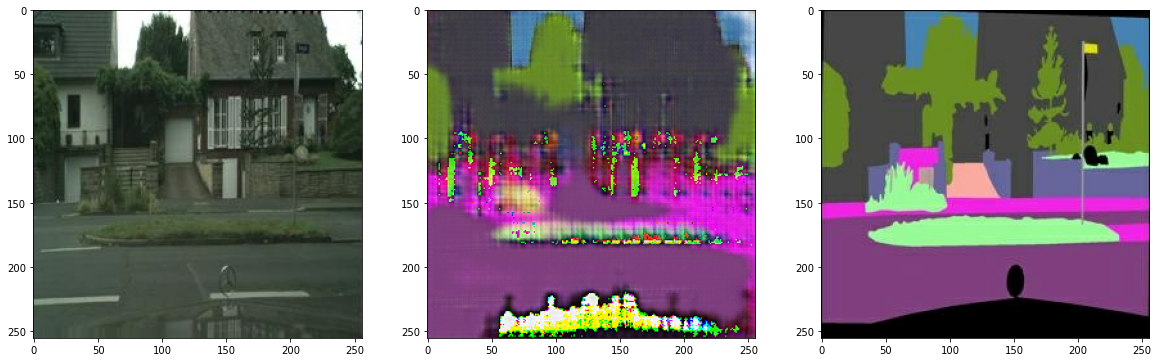

In [27]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))